# Code


# Imports

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.stats import chi2_contingency

# User Configuration

In [2]:
SAVE_FIG = True
SAVE_CSV = True  # Save figures

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

N_BOOTSTRAP = 1000 # 500-1000
SAMPLE_SIZE = 5000 # 5% of Sample size
RANDOM_SEED = 42

DATA_DIR = Path("../../data")
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # ensure output folder exists
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="talk",
    palette="colorblind"
)

# Utility Functions

## Load Data & Assign Correct Datatypes

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

## Own CS-Test Implementation

In [4]:
# ------------------------------------------------------------
# χ²-Statistik, p-Wert und Cramér’s V aus zwei 1-D-Arrays
# ------------------------------------------------------------
def chi2_and_cramers_v(real_arr, synth_arr):
    # Quelle kodieren: 0 = real, 1 = synth
    source = np.r_[np.zeros_like(real_arr), np.ones_like(synth_arr)]

    # 2 × k-Kontingenztabelle
    table = pd.crosstab(
        pd.Series(np.r_[real_arr, synth_arr], name="value"),
        pd.Series(source,                     name="source")
    )

    # χ² ohne Yates-Korrektur
    chi2, p, _, _ = chi2_contingency(table, correction=False)

    n = table.values.sum()
    k = table.shape[0]                      # Kategorien
    v = np.sqrt(chi2 / (n * (k - 1))) if k > 1 else 0.0

    return chi2, p, v


# ------------------------------------------------------------
# Bootstrap-Funktion (parallel)
# ------------------------------------------------------------
def bootstrap_chi2_v_parallel(
    df_real: pd.DataFrame,
    df_synth: pd.DataFrame,
    cat_cols: list,
    n_bootstrap: int = 1000,
    n_sample_size: int | None = None,   # None = volle Länge
    n_jobs: int = -1,
    random_state: int | None = None,
) -> pd.DataFrame:

    rng = np.random.default_rng(random_state)          # global RNG

    def one_iteration(seed):
        rs = np.random.default_rng(seed)               # Worker-RNG
        stats = {}
        for col in cat_cols:
            real = df_real[col].dropna().values
            synth = df_synth[col].dropna().values

            n_r = len(real)  if n_sample_size is None else min(n_sample_size, len(real))
            n_s = len(synth) if n_sample_size is None else min(n_sample_size, len(synth))

            real_s  = rs.choice(real,  n_r, replace=True)
            synth_s = rs.choice(synth, n_s, replace=True)

            chi2, p, v = chi2_and_cramers_v(real_s, synth_s)
            stats[f"{col}_chi2"] = chi2
            stats[f"{col}_p"]    = p
            stats[f"{col}_V"]    = v
        return stats

    seeds = rng.integers(0, 2**32 - 1, size=n_bootstrap, dtype=np.uint64)

    # loky ist der Standard-Backend für parallele Prozesse in Joblib (ab Version 0.12+). Prozessbasiert	CPU-intensive Aufgaben, überall	Etwas langsameres Starten als Threads
    # Alternativen wären "threading" (Thread-basiert, IO-intensive Aufgaben, überall) oder "multiprocessing" (Prozessbasiert, CPU-intensive Aufgaben, nur Linux/MacOS)
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(one_iteration)(s) for s in tqdm(seeds, desc="Bootstrap χ² + V")
    )

    return pd.DataFrame(results)          # Zeilen = Bootstraps, Spalten = Stats


In [5]:
def plot_ci_stability(df_results: pd.DataFrame, feature_col: str, bootstrap_sizes: list = None, figsize: Tuple[int, int] = (12, 6)):
    """
    Plots the stability of the 95% confidence interval of the Cramérs V
    for a given feature using seaborn.
    
    Args:
        df_results (pd.DataFrame): Cramérs V (Bootstrap Iterations x Features)
        feature_col (str): Feature to visualize
        bootstrap_sizes (list, optional): List of bootstrap sample sizes to evaluate
    """
    if bootstrap_sizes is None:
        bootstrap_sizes = [10, 50, 100, 200, 500, 1000]
    
    ci_results = []
    for n in bootstrap_sizes:
        sample_stats = df_results[feature_col].iloc[:n]
        lower = np.percentile(sample_stats, 2.5)
        upper = np.percentile(sample_stats, 97.5)
        mean_stat = np.mean(sample_stats)
        
        ci_results.append({
            'n_bootstrap': n,
            'cs_stat_mean': mean_stat,
            'cs_stat_2_5': lower,
            'cs_stat_97_5': upper
        })
    
    df_ci_results = pd.DataFrame(ci_results)
    
    # Plot with seaborn
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.lineplot(data=df_ci_results, x='n_bootstrap', y='cs_stat_mean', marker='o', ax=ax, label='Mean Cramérs V', )
    
    # Confidence Interval fill (manual, asymmetric)
    ax.fill_between(df_ci_results['n_bootstrap'], 
                    df_ci_results['cs_stat_2_5'], 
                    df_ci_results['cs_stat_97_5'], 
                    alpha=0.3, label='95% Confidence Interval')
    
    ax.set_xlabel('Number of Bootstrap Iterations')
    ax.set_ylabel(f'Cramérs V ({feature_col})')
    ax.set_title(f'Stability of the 95% Confidence Interval of the Cramérs V ({feature_col}) with Increasing Bootstrap Size')
    ax.legend()
    # ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xscale('log')
    
    return fig, ax


In [6]:
def plot_featurewise_ci(df_results: pd.DataFrame, figsize: Tuple[int, int] = (12, 6)):
    """
    Plots Cramérs V with 95% Confidence Intervals per Feature using seaborn.
    
    Args:
        df_results (pd.DataFrame): Bootstrap results (Iterations x Features)
    """
    summary = []
    for col in df_results.columns:
        lower = np.percentile(df_results[col], 2.5)
        upper = np.percentile(df_results[col], 97.5)
        mean_stat = df_results[col].mean()
        
        summary.append({
            'feature': col,
            'cs_stat_mean': mean_stat,
            'cs_stat_2_5': lower,
            'cs_stat_97_5': upper
        })
    
    df_summary = pd.DataFrame(summary)
    
    # Fehlerbalken (hue-less)
    df_summary['err_low'] = df_summary['cs_stat_mean'] - df_summary['cs_stat_2_5']
    df_summary['err_high'] = df_summary['cs_stat_97_5'] - df_summary['cs_stat_mean']
    
    # Für seaborn -> barplot mit Custom CI (zwei Seiten unterschiedlich => Pointplot+manual errorbars)
    fig, ax = plt.subplots(figsize=figsize)

    sns.pointplot(
        data=df_summary,
        x='feature',
        y='cs_stat_mean',
        linestyle='none',
        capsize=0.2,
        color='steelblue',
        ax=ax
    )
    
    # Fehlerbalken manuell (weil asymmetrisch)
    for i, row in df_summary.iterrows():
        err_low = max(0, abs(row['err_low']))
        err_high = max(0, abs(row['err_high']))

        ax.errorbar(
            x=i, 
            y=row['cs_stat_mean'], 
            yerr=[[err_low], [err_high]], 
            fmt='none', 
            # ecolor='red', 
            elinewidth=1.5, 
            capsize=5
        )

    ax.set_xlabel('Feature')
    ax.set_ylabel('Cramérs V')
    ax.set_title('Cramérs V with 95% Confidence Intervals per Feature')
    plt.xticks(ticks=range(len(df_summary['feature'])), labels=df_summary['feature'], rotation=45, ha='right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    return fig, ax


# Main Routine
## Daten Laden

In [7]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)

In [8]:
num_attrs = df_real.select_dtypes(include=['number']).columns
cat_attrs = df_real.select_dtypes(exclude=['number']).columns

# Bootstrap

In [9]:
df_results = bootstrap_chi2_v_parallel(df_real, df_synth, cat_cols=cat_attrs, n_bootstrap=N_BOOTSTRAP, n_sample_size=SAMPLE_SIZE, random_state=RANDOM_SEED)

Bootstrap χ² + V: 100%|██████████| 1000/1000 [00:44<00:00, 22.26it/s]


In [10]:
df_results_cramersV = df_results.filter(like='_V')
# print(df_results_cramersV.head())

In [11]:
if SAVE_CSV:
    df_results.to_csv(OUTPUT_DIR_CSV / f"cramersV_bootstrap_{N_BOOTSTRAP}_results.csv", index=False, sep=";", decimal=",", encoding="utf-8")
    print(f"Bootstrap results saved to {OUTPUT_DIR_CSV / f'cramersV_bootstrap_{N_BOOTSTRAP}_results.csv'}")

Bootstrap results saved to results\cramersV_bootstrap_1000_results.csv


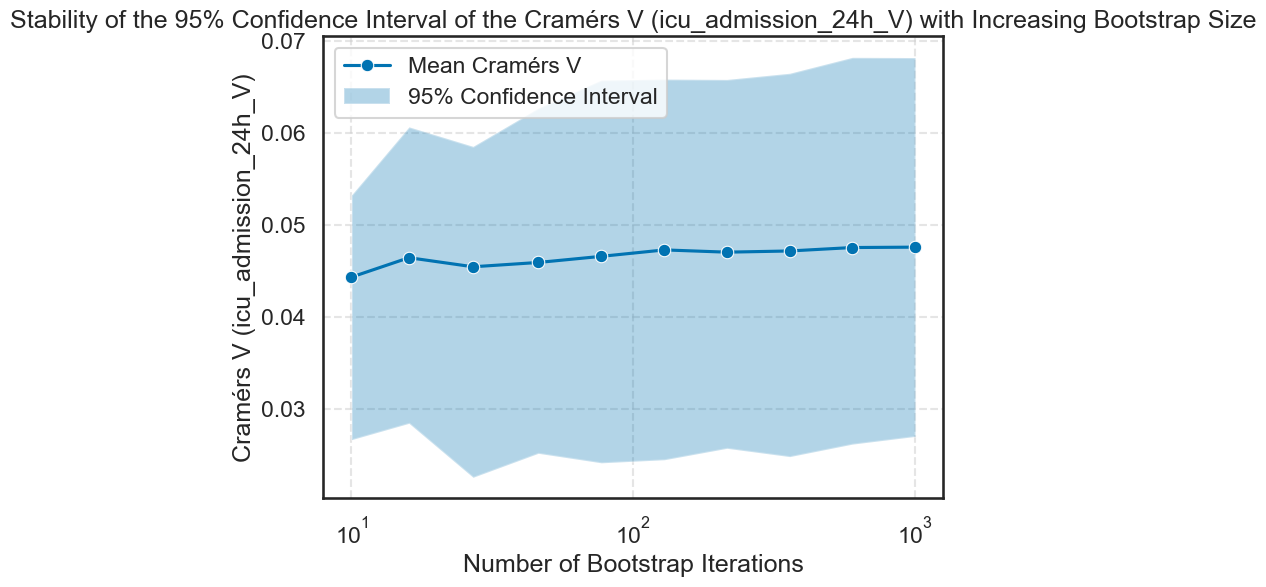

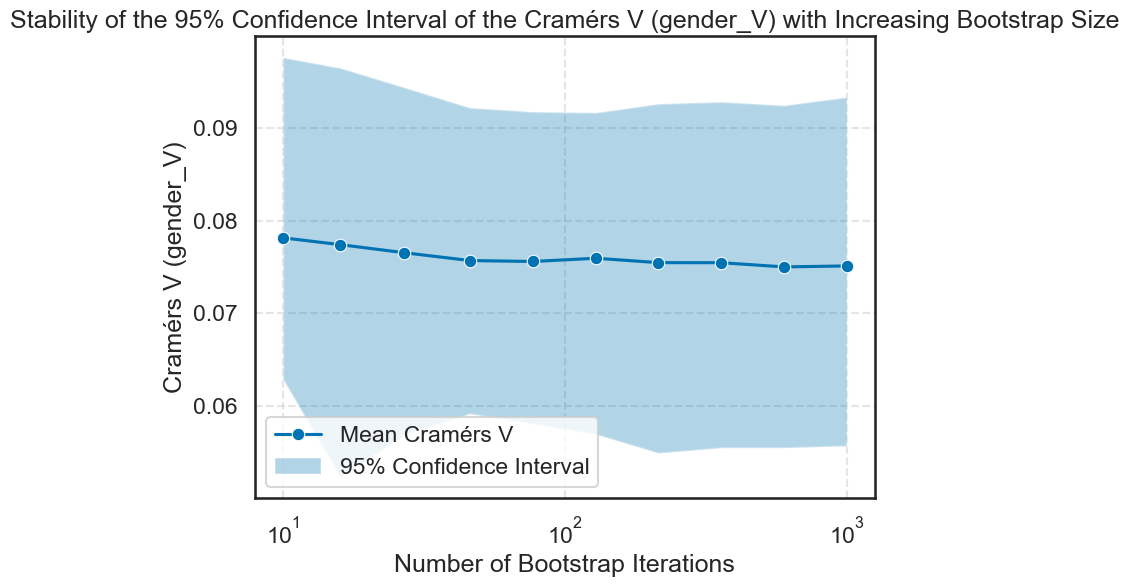

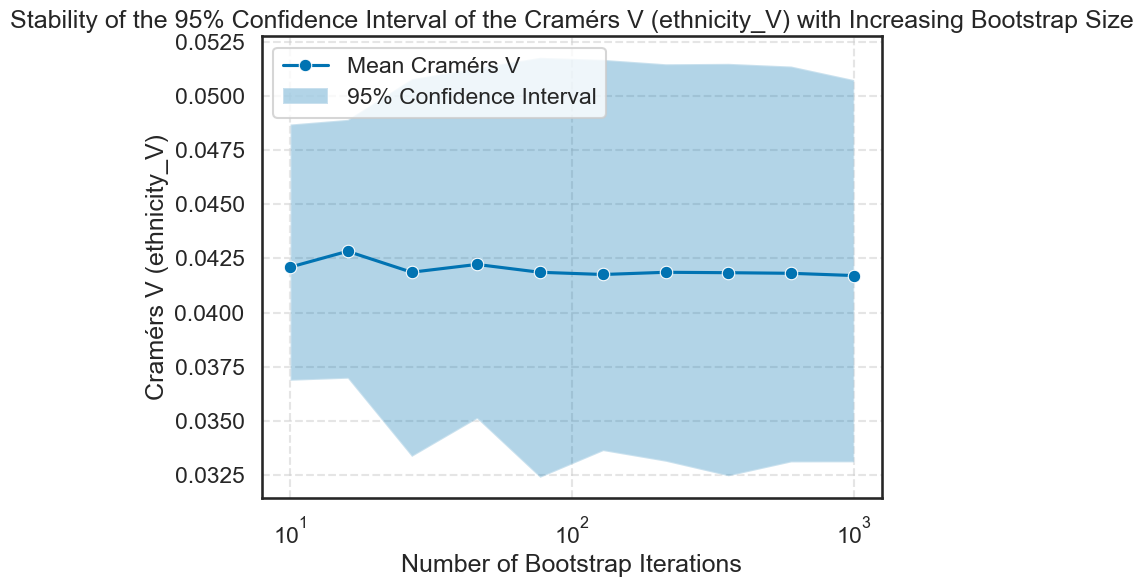

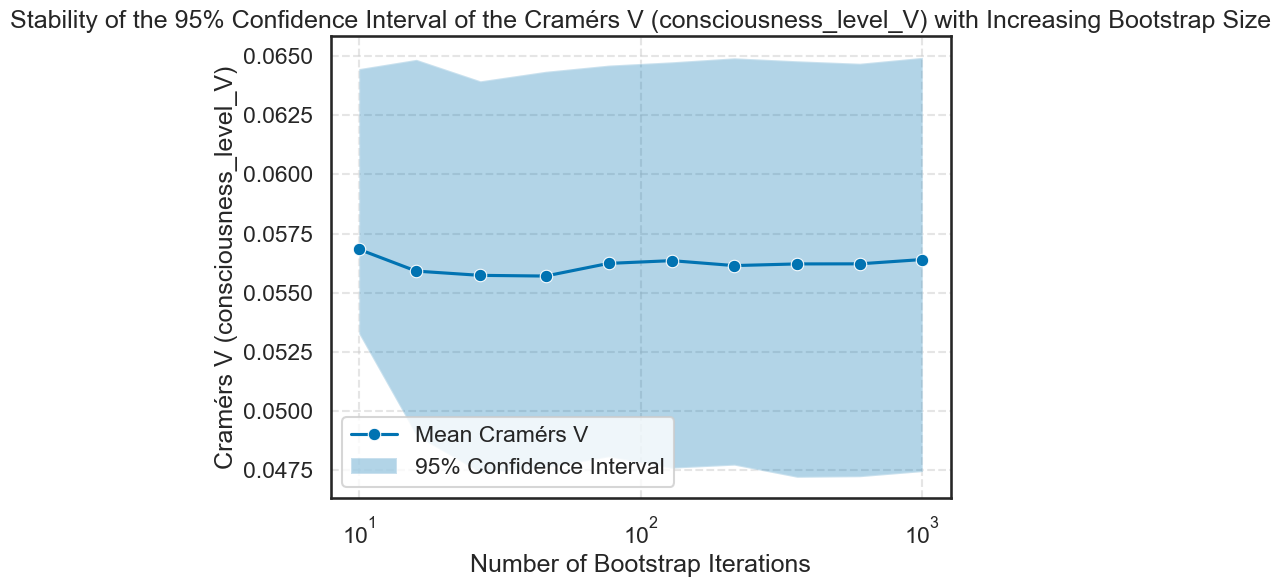

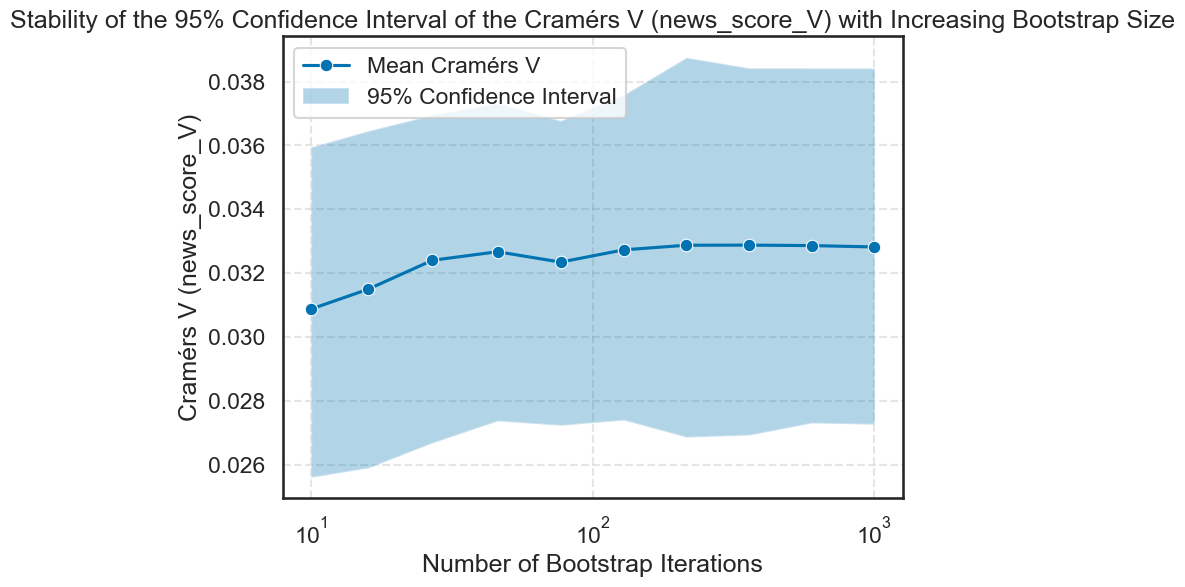

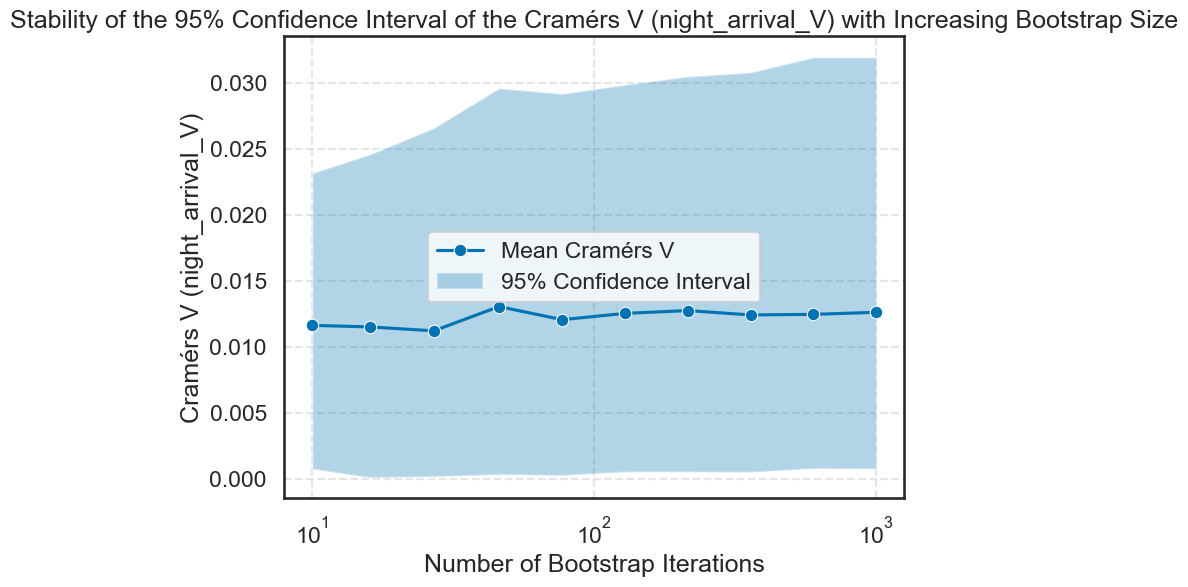

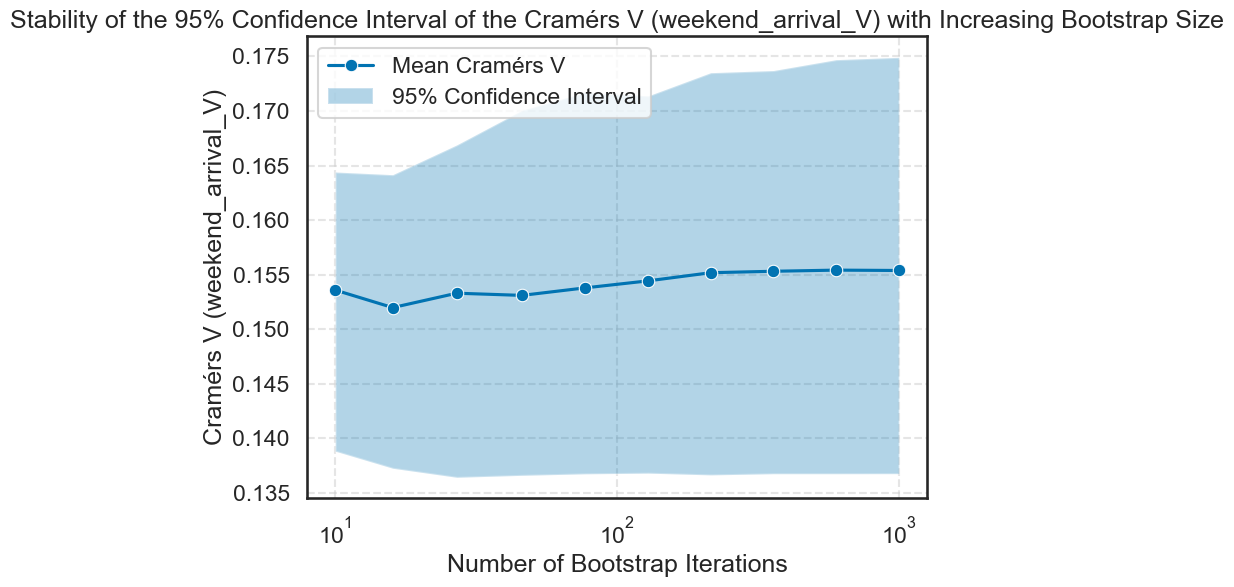

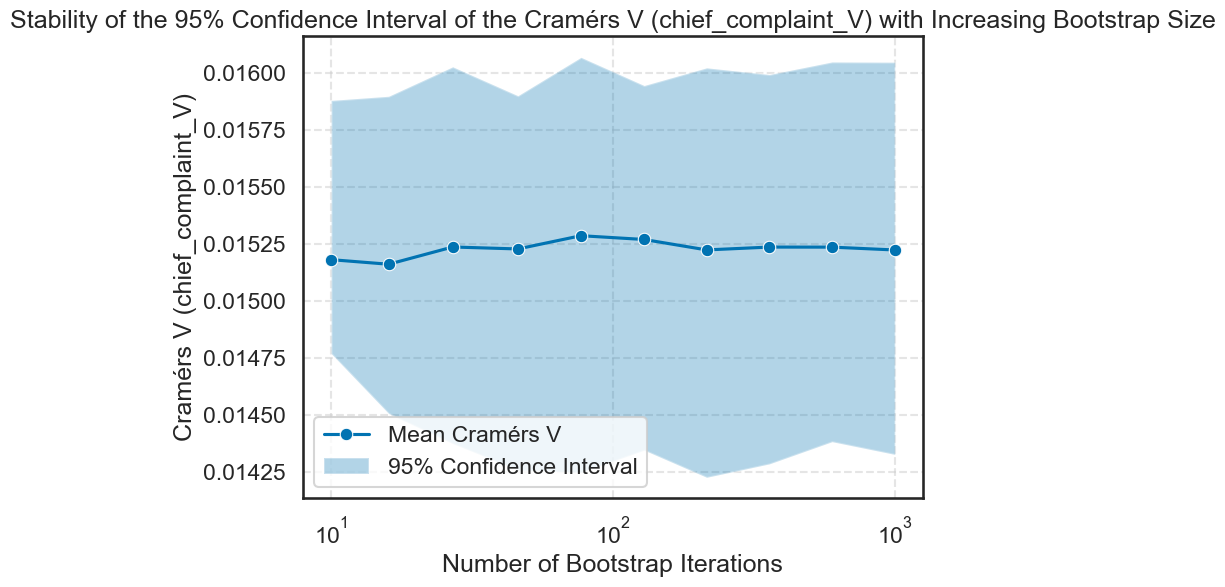

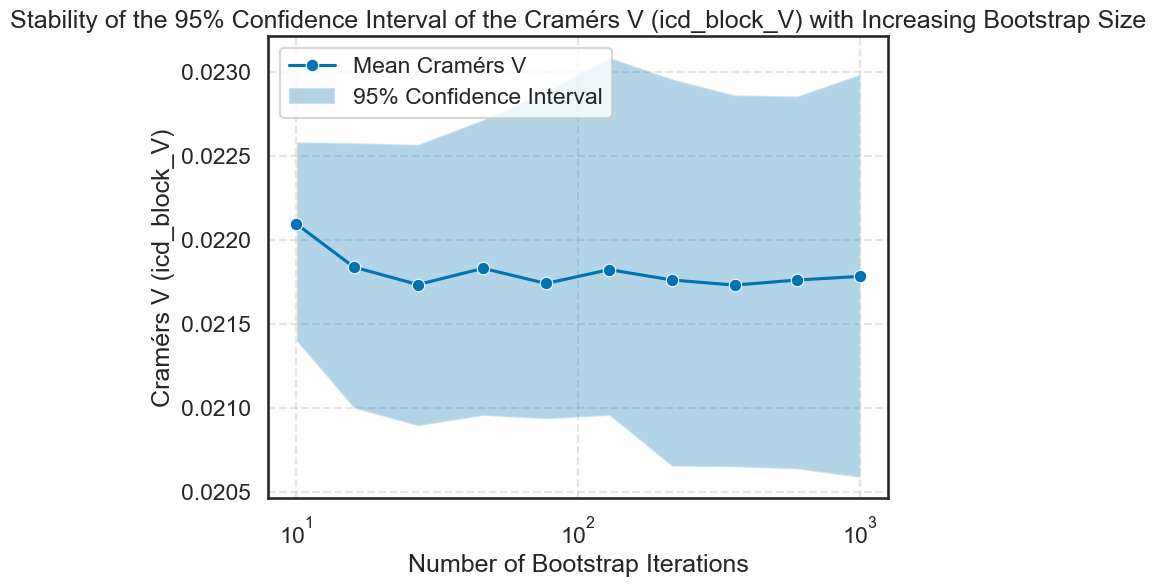

In [12]:
# bootstrap_sizes = np.linspace(10, N_BOOTSTRAP, N_STEPS, dtype=int).tolist()
bootstrap_sizes = np.unique(np.geomspace(10, N_BOOTSTRAP, num=10, dtype=int)).tolist()

# attr = "age"

for attr in df_real[cat_attrs]:
    fig, ax = plot_ci_stability(df_results=df_results_cramersV, feature_col=f'{attr}_V', bootstrap_sizes=bootstrap_sizes, figsize=(8, 6))
    plt.show()
    if SAVE_FIG:
        output_dir_ci = OUTPUT_DIR_FIG / "CV_CI-Sability"
        output_dir_ci.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_dir_ci / f"cramersV_ci_stability_{attr}_{N_BOOTSTRAP}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
    plt.close(fig)

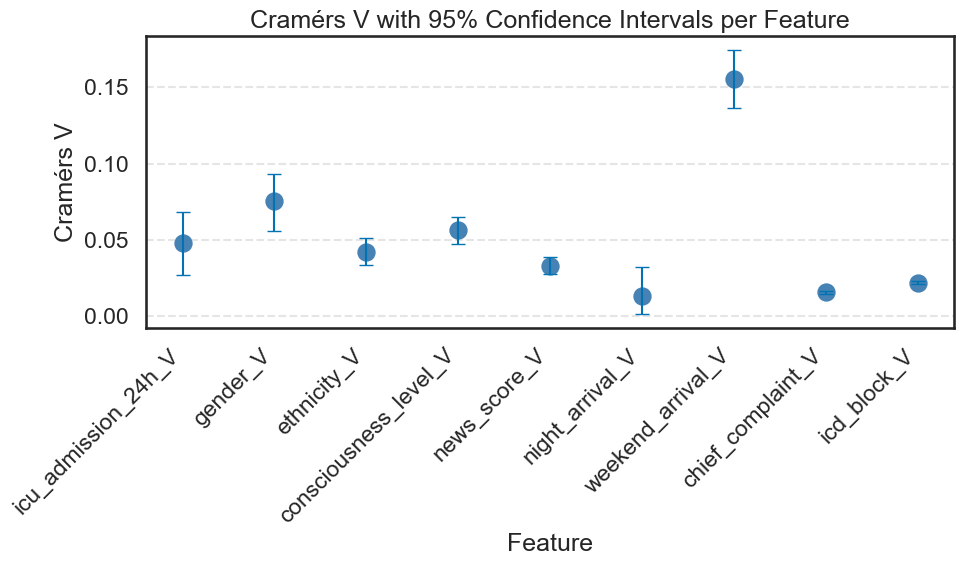

In [13]:
fig, ax = plot_featurewise_ci(df_results_cramersV, figsize=(10, 6))
plt.show()
if SAVE_FIG:
    fig.savefig(OUTPUT_DIR_FIG / f"cramersV_all_features_{N_BOOTSTRAP}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)